# Проект: Обучение с учителем: качество модели

## Введение

### Описание проекта


Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Цель проекта

Требуется разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Задачи проекта

    1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
    2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
    3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
    
### Исходные данные


1. market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

2. market_money.csv
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

3. market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

4. money.csv
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [1]:
pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif


In [5]:
#показ первичной информации

def show_primary_info(df):
    display(df.head())
    df.info()

## Загрузка данных

### Таблица с общими данными

In [6]:
market = pd.read_csv('/datasets/market_file.csv',sep=',')
show_primary_info(market)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### Таблица с данными о выручке

In [7]:
market_money = pd.read_csv('/datasets/market_money.csv',sep=',')
show_primary_info(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### Таблица с данными о времени

In [8]:
market_time = pd.read_csv('/datasets/market_time.csv',sep=',')
show_primary_info(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### Таблица с данными о среднемесячной прибыли покупателя

In [9]:
money = pd.read_csv('/datasets/money.csv',sep=';',decimal=',')
show_primary_info(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод**

Предоставленые датасеты загружены. Их содержимое соответствует описанию, данные представлены в достточном объеме, пропусков в данных нет.

## Предобработка данных

In [10]:
def correct_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
    return df.columns

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [11]:
def convert_to_float(df,columns):
    for col in columns:
        df[col] = df[col].replace(to_replace=r",", value=".", regex=True)
        df[col] = df[col].astype('float')
    return df

In [12]:
def drop_duplicates_data(df):
    print("Количество дубликатов строк в датасете: ", df.duplicated().sum())
    if  df.duplicated().sum() > 0:
        df = df.drop_duplicates().reset_index(drop = True)
        print("Количество дубликатов строк в датасете после удаления: ", df.duplicated().sum())
    return df

In [13]:
def preprocess_data(df, float_columns=[], category_columns = [], replaces = {}):
    df.columns = correct_columns(df)
    df = convert_to_float(df,float_columns)
    show_primary_info(df)
    
    for col in category_columns:
        print(col, df[col].unique())
        if col in replaces:
            for f in replaces[col]:
                df[col] = df[col].replace(f,replaces[col][f])
            print(col,"(после замены)", df[col].unique())
    
    df = drop_duplicates_data(df)
    return df

### Таблица с общими данными

In [14]:
market=preprocess_data(
    df = market,
    category_columns=['покупательская_активность','тип_сервиса','разрешить_сообщать','популярная_категория'],
    replaces={'тип_сервиса':{'стандартт':'стандарт'}}
)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Таблица с данными о выручке

In [15]:
market_money=preprocess_data(
    df = market_money,
    category_columns=['период'],
    replaces={}
)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Количество дубликатов строк в датасете:  0


### Таблица с данными о времени

In [16]:
market_time=preprocess_data(
    df = market_time,
    category_columns=['период'],
    replaces={'период':{'предыдцщий_месяц':'предыдущий_месяц'}}
)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
период ['текущий_месяц' 'предыдцщий_месяц']
период (после замены) ['текущий_месяц' 'предыдущий_месяц']
Количество дубликатов строк в датасете:  0


### Таблица с данными о среднемесячной прибыли покупателя

In [17]:
money=preprocess_data(
    df = money,
    float_columns = ['прибыль']
)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
Количество дубликатов строк в датасете:  0


**Выводы**

Все представленные датасеты проверены и в них:

    - исправлены наименования столбцов
    - типы данных исправлены на корректные (при необходимости)
    - удалены дубликаты категориальных значений (при необходимости)
    - проведена проверка на полные дубликаты



Датасеты готовы к исследователькому анализу данных


##  Исследовательский анализ данных

In [18]:
def analis_data(df, number_columns=[], category_columns = []):    
    for col in category_columns:
        (
            df[col]
            .value_counts()
            .plot(kind='pie', title = 'Распределение по параметру '+col,  autopct='%1.0f%%')
        )
        plt.xlabel(col)
        plt.ylabel('Кол-во покупателей')
        plt.show()
    for col in number_columns:
        (
            df[col]
            .plot(kind='hist', bins=100, title = 'Распределение по параметру '+col)
        )
        plt.xlabel(col)
        plt.ylabel('Кол-во покупателей')
        plt.show()
        print(df[col].describe())
    

### Таблица с общими данными

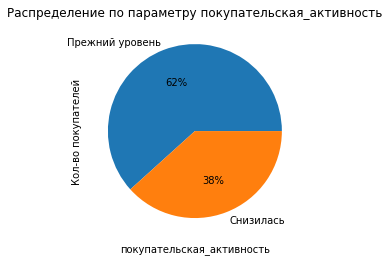

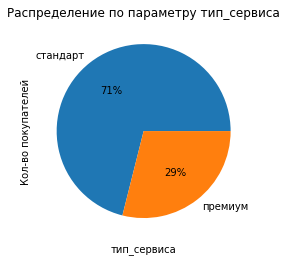

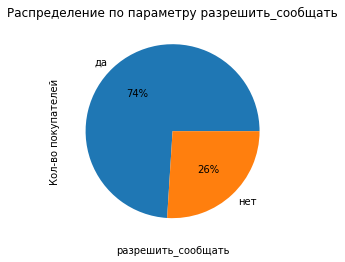

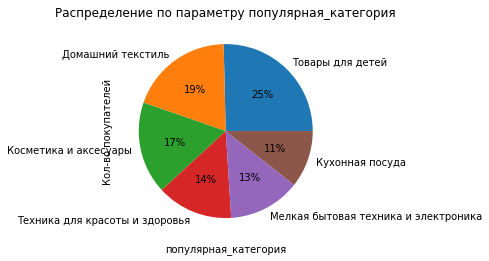

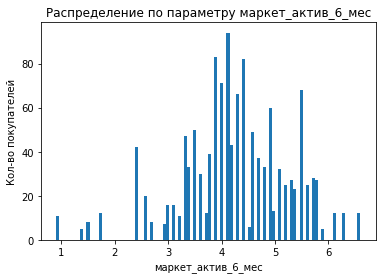

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


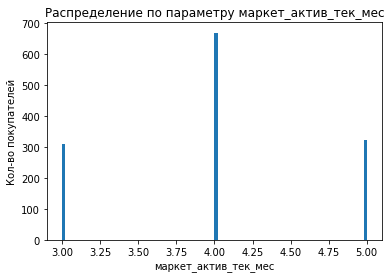

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


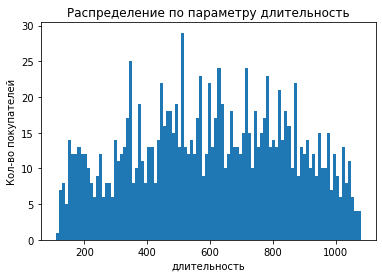

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


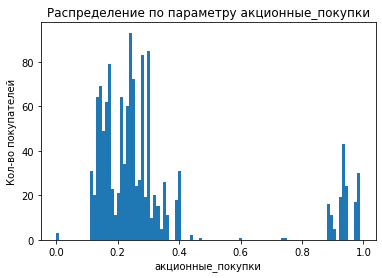

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


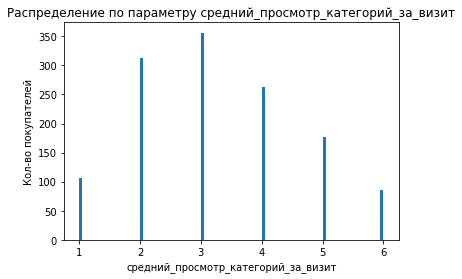

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


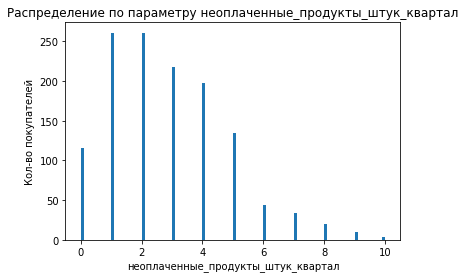

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


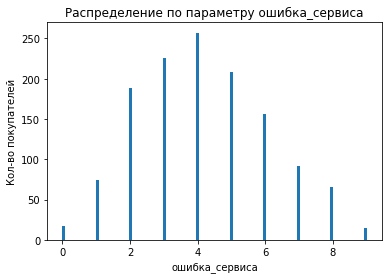

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


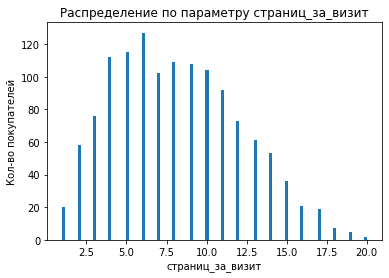

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


In [19]:
analis_data(
    df = market,
    category_columns=['покупательская_активность','тип_сервиса','разрешить_сообщать','популярная_категория'],
    number_columns=['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']
)

**Выводы**

- Категориальные признаки представлены не в равных долях в выборке. В т.ч. наблюдается дисбаланс целевого класса
- Параметр маркет_актив_тек_мес имеет только три варианта значений и может быть переведен в категориальный
- Параметр акционные_покупки может быть легко поделен по значениям на две группы и переведен в категориальный

### Таблица с данными о выручке

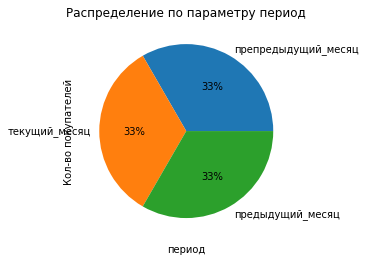

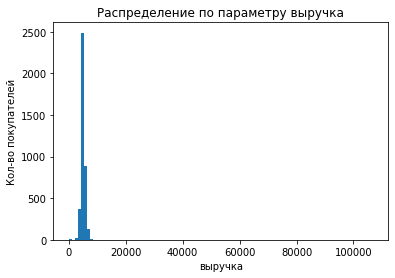

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64


In [20]:
analis_data(
    df = market_money,
    category_columns=['период'],
    number_columns=['выручка']
)

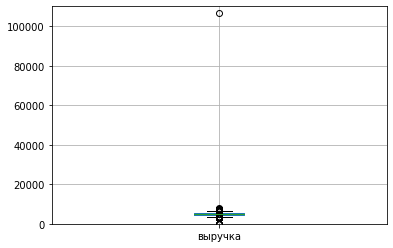

In [21]:
plt.ylim(0,110000)

market_money.boxplot(column=['выручка']) 
plt.show()

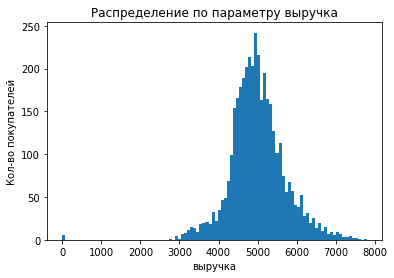

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64


In [22]:
market_money = market_money.query("выручка<20000")

analis_data(
    df = market_money,
    category_columns=[],
    number_columns=['выручка']
)

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>Действительно явный выброс.
Можно удалить, а можно и заполнить, например значением предыдущего месяца.</font>

Анализ за период препредыдущий_месяц


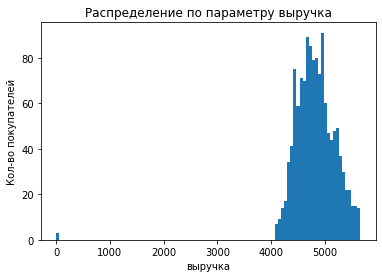

count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: выручка, dtype: float64
Анализ за период текущий_месяц


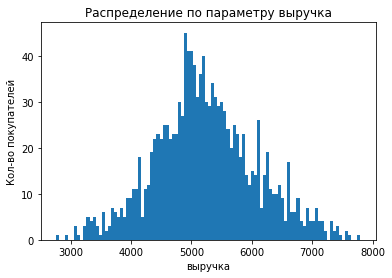

count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: выручка, dtype: float64
Анализ за период предыдущий_месяц


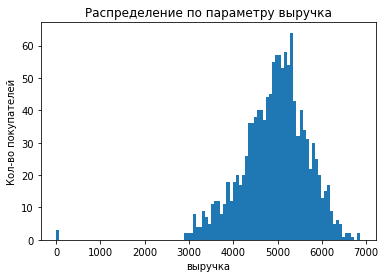

count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: выручка, dtype: float64


In [23]:
for period in market_money['период'].unique():
    print("Анализ за период",period)
    analis_data(
        df = market_money[market_money['период']==period],
        number_columns=['выручка']
    )

In [24]:
market_money.groupby('id').filter(lambda x: (x['период'].nunique() < 3) | (x['выручка'].min() == 0))

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
96,215380,препредыдущий_месяц,5051.0


In [25]:
market_money = market_money.groupby('id').filter(lambda x: (x['период'].nunique() == 3) & (x['выручка'].min() > 0))

**Выводы**

- Параметр Выручка имеет значительные выбросы в данных за текущий период. Будем трактовать выброс как ошибочные данные и удалим его
- Наблюдается рост среднего значения выручки от препредыдущего периода к текущему
- Данные за различные периоды представлены в равных пропорциях и похожий разброс ( за исключением выбросов в текущем периоде)
- Для части клиентов наблюдается отстуствие покупок в течение всех трех месяцев, исключим их из выборки

### Таблица с данными о времени

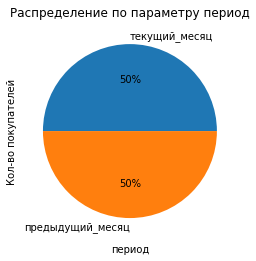

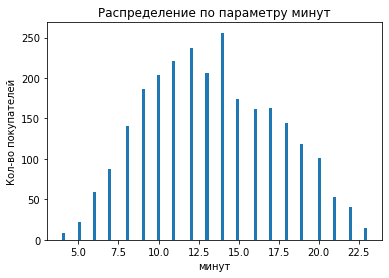

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


In [26]:
analis_data(
    df = market_time,
    category_columns=['период'],
    number_columns=['минут']
)

Анализ за период текущий_месяц


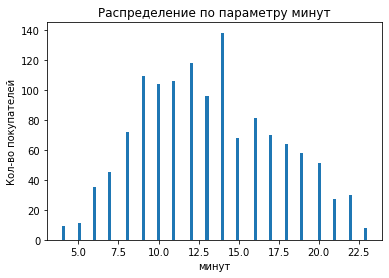

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64
Анализ за период предыдущий_месяц


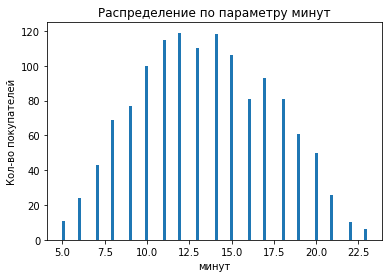

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут, dtype: float64


In [27]:
for period in market_time['период'].unique():
    print("Анализ за период",period)
    analis_data(
        df = market_time[market_time['период']==period],
        number_columns=['минут']
    )

**Выводы**

- Данные представлены только за два периода в равных пропорциях
- Параметр минут выбросов не имеет, за разные периоды разброс значений существенно не меняется

### Таблица с данными о среднемесячной прибыли покупателя

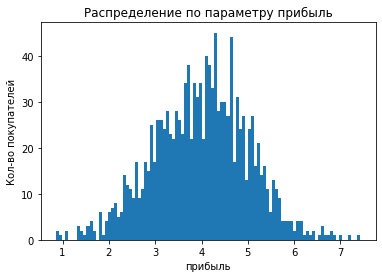

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


In [28]:
analis_data(
    df = money,
    number_columns=['прибыль']
)

**Выводы**

Параметр прибыль выбросов не имеет

**Выводы**

 - Общие данные о покупателях: количественные параметры выбросов не имеют, категориальные данные представлены не в равных пропорциях, несколько параметром ( маркет_актив_тек_мес и акционные_покупки) могут быть переведены в категориальные
 - данные о выручке представлены в равных пропорциях по периодам, наблюдаются выбросы
 - данные о времени представлены в равных пропоруциях по периодам, выбросов не наблюдается
 - данные о прибыли значительных выбросов не имеют. Вероятно значение прибыли представлено в иных единицах чем выручка.


##  Объединение таблиц

In [29]:
for period in market_money['период'].unique():
    df = market_money[market_money['период']==period]
    df=df.drop(['период'],axis=1)
    df=df.rename(columns = {'выручка':'выручка_'+period})
    market=market.merge(df, on = 'id')

print(market.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [30]:
for period in market_time['период'].unique():
    df = market_time[market_time['период']==period]
    df=df.drop(['период'],axis=1)
    df=df.rename(columns = {'минут':'минут_'+period})
    market=market.merge(df, on = 'id')

market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

**Выводы**

В датафрейм с общими данными были добавлены столбцы из датафреймов с данными о прибыли и времени на сайте по периодам. Каждому периоду соответствует отдельный столбец. Пропусков в объединенных данных не появилось

## Корреляционный анализ

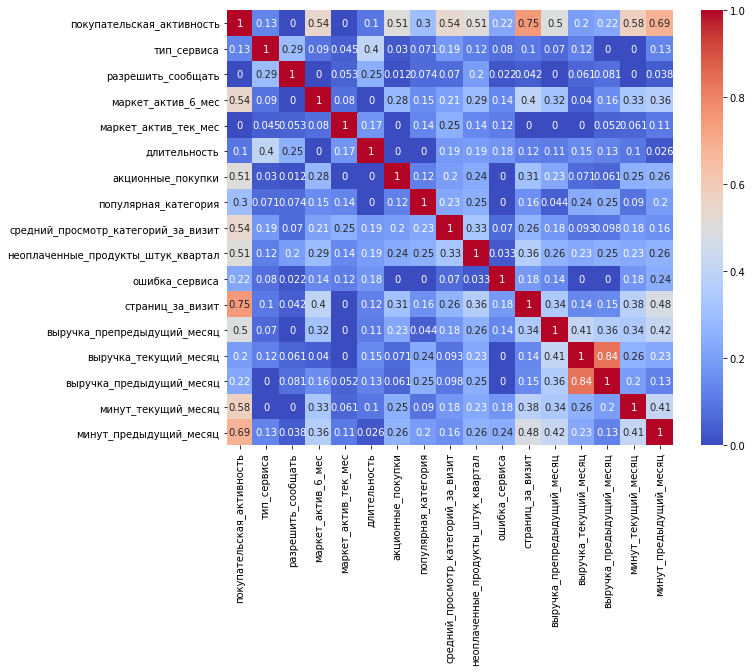

In [31]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    market.drop(["id"],axis=1).phik_matrix(
        interval_cols= ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит','выручка_текущий_месяц','выручка_предыдущий_месяц','выручка_препредыдущий_месяц','минут_текущий_месяц','минут_предыдущий_месяц']
    ), 
    annot=True, 
    cmap='coolwarm'
)

plt.show()

In [32]:

market['минут_динамика']=np.where((market['минут_текущий_месяц']-market['минут_предыдущий_месяц'])>0,"увеличилось","снизилось")
market['маркет_динамика']=np.where((market['маркет_актив_тек_мес']-market['маркет_актив_6_мес'])>0,"увеличилось","снизилось")
market['выручка_среднее']=(market['выручка_текущий_месяц']+market['выручка_предыдущий_месяц']+market['выручка_препредыдущий_месяц'])/3
market['уровень_акционных_покупок']=np.where(market['акционные_покупки']>0.6,"покупки по акциям","покупки без акций")
market['средняя_выручка_со_страницы']=market['выручка_среднее'] / market['страниц_за_визит']


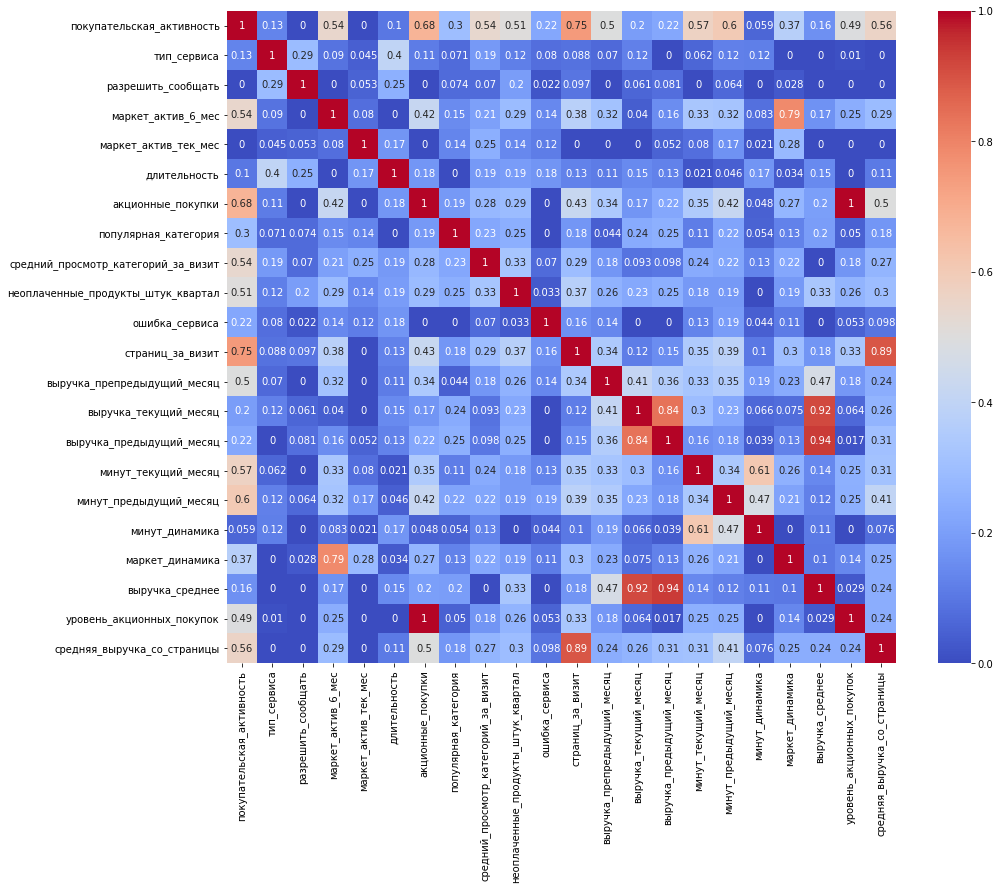

In [33]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    market.drop(["id"],axis=1).phik_matrix(
        interval_cols= ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность',
                        'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал','ошибка_сервиса','выручка_текущий_месяц',
               'выручка_предыдущий_месяц','выручка_препредыдущий_месяц','выручка_среднее',
                        'средняя_выручка_со_страницы']
    ), 
    annot=True, 
    cmap='coolwarm'
)

plt.show()

**Выводы**

Корреляционный анализ выявил высокие значения коэффициента корреляции с целевым признаком у ряда параметров. Для предотвращения мультиколлениарности были:
- созданы на основе существующих количественные признаки выручка_среднее, средняя_выручка_со_страницы
- созданы на основе существующих категориальный признак минут_динамика
- признак акционные_покупки был преобразован в категориальный уровень_акционных_покупок

##  Использование пайплайнов

In [34]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['id','покупательская_активность',"акционные_покупки",'страниц_за_визит',"минут_текущий_месяц",'минут_предыдущий_месяц'], axis=1),
    market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['покупательская_активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса','разрешить_сообщать','минут_динамика','маркет_динамика','уровень_акционных_покупок']
num_columns = ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал','ошибка_сервиса','выручка_текущий_месяц',
               'выручка_предыдущий_месяц','выручка_препредыдущий_месяц','выручка_среднее','средняя_выручка_со_страницы']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
#('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
#         ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))

ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт','премиум'],
                    ['нет','да'],
                    ['снизилось', 'увеличилось'], 
                    ['снизилось', 'увеличилось'],
                    ["покупки без акций","покупки по акциям"]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)

# создаём общий пайплайн для подготовки данных
#     ('ord', ord_pipe, ord_columns),
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['нет',
                          

- при разделении данных на выборки была использована стратификация по целевому признаку по причине его дисбаланса в исходном датасете
- оптимальная метрика  ROC-AUC. Она отлично подходит для бинарной классификации с несбалансированной выборкой. 
- лучшая модель - LogisticRegression с настройками C=2, class_weight='balanced', penalty='l1',  solver='liblinear', значение метрики ROC-AUC 0,889 на тренировочной и 0,9 на тестовой выборке


## Анализ важности признаков

In [35]:
model=randomized_search.best_estimator_.named_steps['models']

preprocessor=randomized_search.best_estimator_.named_steps['preprocessor']

# Получение имён преобразованных признаков
feature_names = num_columns + ord_columns
feature_names += list(preprocessor.named_transformers_['ohe']['ohe'].get_feature_names())


X_train_p = pd.DataFrame(
    randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train),
    columns=feature_names
)

X_test_p = pd.DataFrame(
    randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test),
    columns=feature_names   
) 

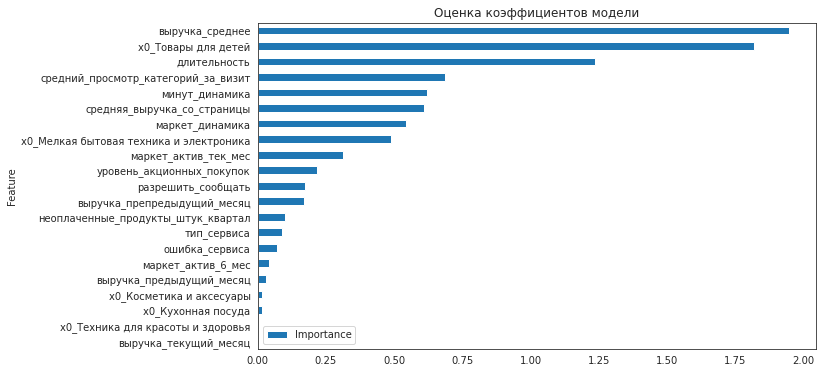

In [36]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance',ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Оценка коэффициентов модели")
plt.show()

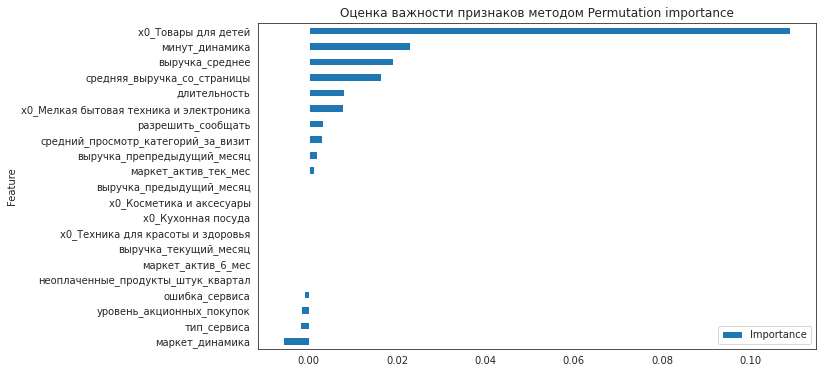

In [37]:
result = permutation_importance(model, X_test_p, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Оценка важности признаков методом Permutation importance")
plt.show()

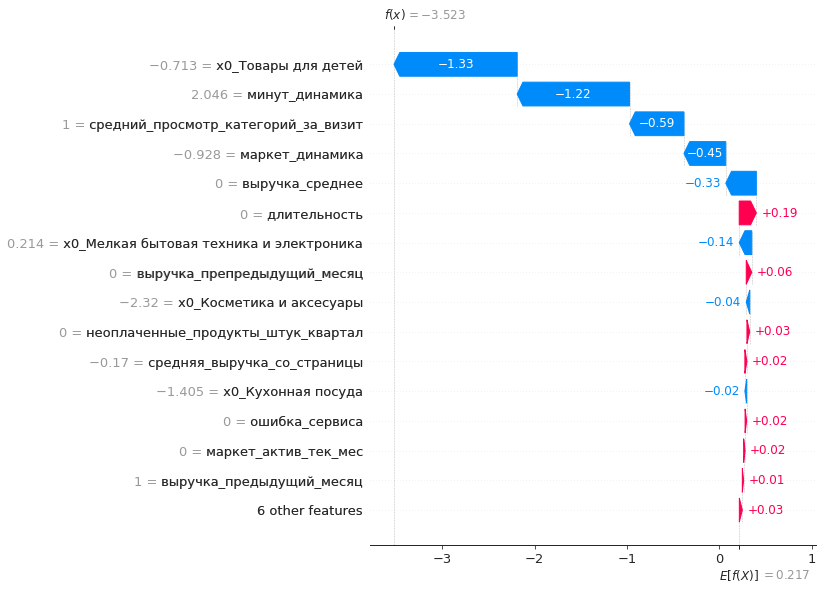

In [38]:
explainer = shap.LinearExplainer(model, X_test_p)
shap_values = explainer(X_test_p)
#shap.plots.bar(shap_values) 
shap.plots.waterfall(shap_values[0], max_display=16) 

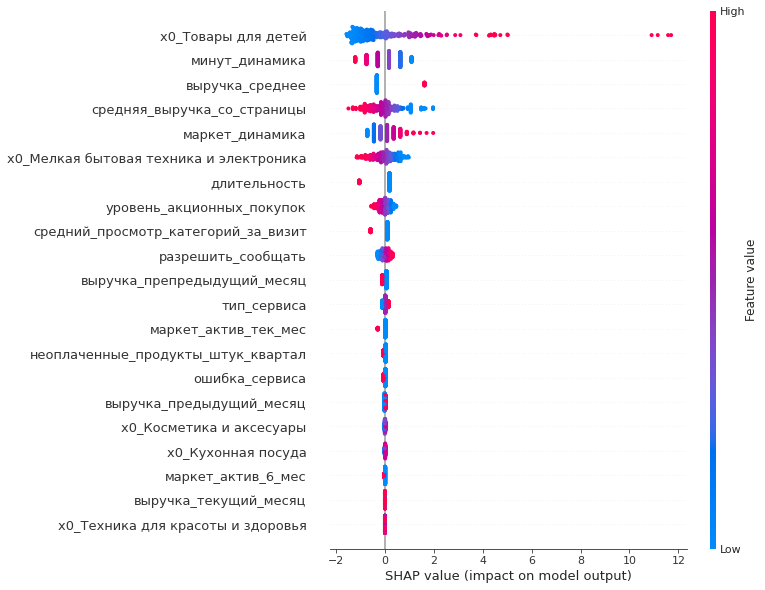

In [39]:
shap.plots.beeswarm(shap_values, max_display=22) 

**Выводы**

Оценка важности признаков показала, что 
- наиболее значимыми для модели выступают признаки минут_динамика, выручка_среднее, средняя_выручка_со_страницы, принадлежность к некоторым категориям
- наименнее значимыми -  выручка_текущий_месяц, выручка_предыдущий_месяц, ошибки_сервиса
- вероятность снижения покупательской активности выше у следующих типов покупателей:
    - приобретающих технику
    - покупающих преимущественно по акциям
    - имеющих высокую среднюю выручку со страницы, т.е. быстро совершающих покупку и/или соверщающие дорогостоящие покупки
    - имеющих тенденцию проводить меньше времени на сайте
    - тех, количество рассылок которым снижается


## Сегментация покупателей

### Подготовка данных

In [40]:
y_full_pred = randomized_search.predict_proba(market.drop(['id','покупательская_активность',"акционные_покупки",'страниц_за_визит',"минут_текущий_месяц",'минут_предыдущий_месяц'], axis=1),)[:, 1]
market['вероятность_снижения'] = pd.DataFrame(y_full_pred, columns=["вероятность_снижения"])

market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,минут_динамика,маркет_динамика,выручка_среднее,уровень_акционных_покупок,средняя_выручка_со_страницы,вероятность_снижения
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,4971.6,5216.0,10,12,снизилось,снизилось,4886.533333,покупки по акциям,977.306667,0.957315
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,5058.4,5457.5,13,8,увеличилось,снизилось,5113.966667,покупки без акций,1022.793333,0.369368
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6610.4,6158.0,13,11,увеличилось,увеличилось,5853.800000,покупки по акциям,1463.450000,0.940399
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,5872.5,5807.5,11,8,увеличилось,снизилось,5424.666667,покупки по акциям,2712.333333,0.998890
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,5388.5,4738.5,10,10,снизилось,увеличилось,5083.666667,покупки без акций,1270.916667,0.708231


In [41]:
market=market.merge(money, on = 'id')
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Сегментация покупателей

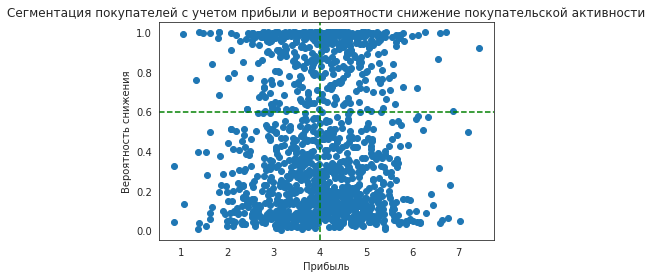

In [42]:
plt.scatter(market['прибыль'], market['вероятность_снижения'])

plt.title('Сегментация покупателей с учетом прибыли и вероятности снижение покупательской активности')
plt.xlabel("Прибыль")
plt.ylabel("Вероятность снижения")
plt.axvline(x=4,color='green',linestyle='--')
plt.axhline(y=0.6,color='green',linestyle='--')
plt.show()

Можно выделить 4 сегмента по соотношению вероятности снижения покупательской активности к прибыли:
- группа клиентов с высокой прибылью и высокой вероятностью снижения покупательской активности
- группа клиентов с высокой прибылью и низкой вероятностью снижения покупательской активности
- группа клиентов с низкой прибылью и высокой вероятностью снижения покупательской активности
- группа клиентов с низкой прибылью и низкой вероятностью снижения покупательской активности

Для бизнеса наиболее интересен первый сегмент клиентов и  было бы полезным исследовать пути предотвращения снижения покупательской активности в нем.

In [43]:
market_explored = market.loc[(market['вероятность_снижения'] > 0.6) & (market['прибыль']>4)]
market['группа']=np.where((market['вероятность_снижения'] > 0.6) & (market['прибыль']>4),"Исследуемая группа","Остальные")
market_explored.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 1284
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   230 non-null    int64  
 1   покупательская_активность            230 non-null    object 
 2   тип_сервиса                          230 non-null    object 
 3   разрешить_сообщать                   230 non-null    object 
 4   маркет_актив_6_мес                   230 non-null    float64
 5   маркет_актив_тек_мес                 230 non-null    int64  
 6   длительность                         230 non-null    int64  
 7   акционные_покупки                    230 non-null    float64
 8   популярная_категория                 230 non-null    object 
 9   средний_просмотр_категорий_за_визит  230 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   230 non-null    int64  
 11  ошибка_сервиса                 

### Исследование группы покупателей

In [44]:
def get_scatters(df,field_x,fields_y,category_fields,field_x_name):
    for field_y in fields_y:
        for category_field in category_fields:
            groups = df.groupby(category_field)
            for name, group in groups:
                plt.scatter(group[field_x], group[field_y], label=name)
    
            plt.legend()
            plt.title('Связь признаков '+field_x_name+' и '+field_y+' с учетом признака '+category_field)
            plt.xlabel(field_x_name)
            plt.ylabel(field_y)
            plt.show()

In [45]:
def get_hists(df,fields_x,fields_y):
    colors=['blue','red'];
    for field_x in fields_x:
        for field_y in fields_y:
            plt.figure(figsize=(10, 8))
            groups = df.groupby(field_y)
            ind=0
            for name, group in groups:
                sns.histplot(data=group[field_x], color=colors[ind], alpha=0.5, kde=True, label=name)
                ind+=1
            
            plt.legend()
            plt.title('Сравнение '+field_x+' с группировкой по '+field_y)
            plt.xlabel(field_x)
            plt.ylabel("Количество")
            if field_x=='популярная_категория':
                plt.xticks(rotation=45)
            plt.show()

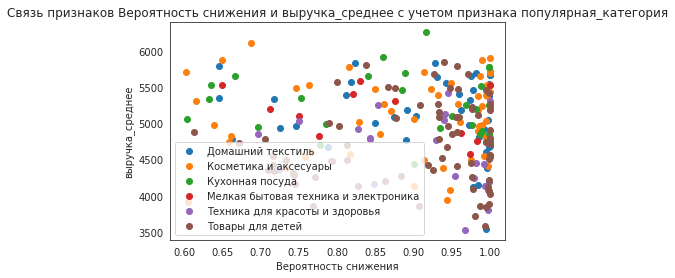

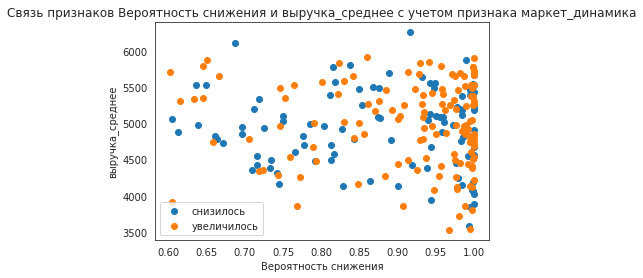

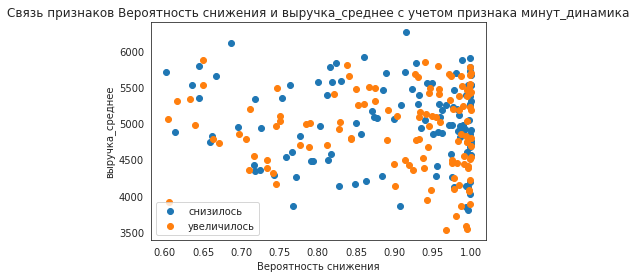

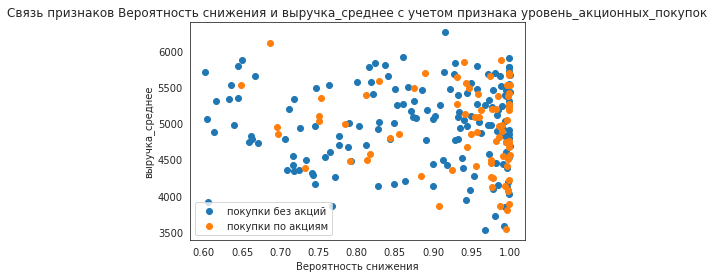

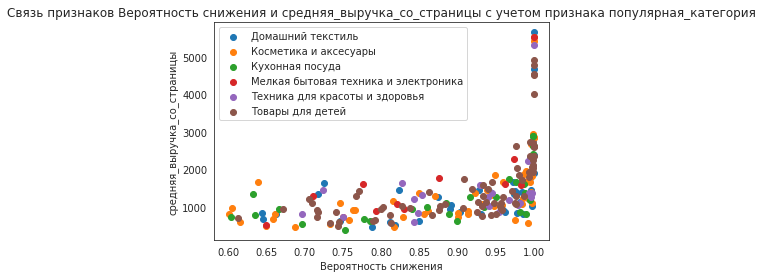

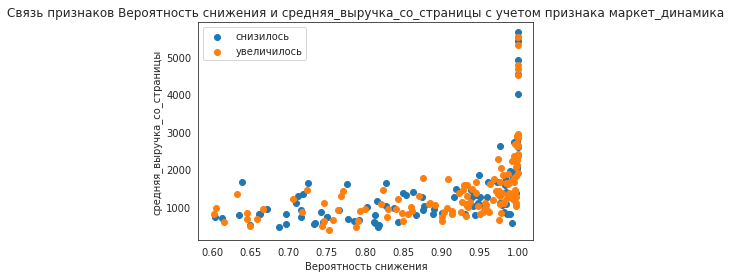

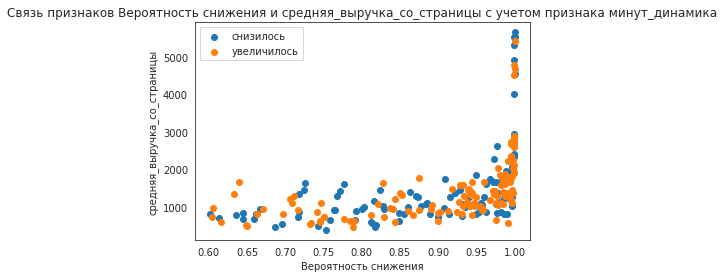

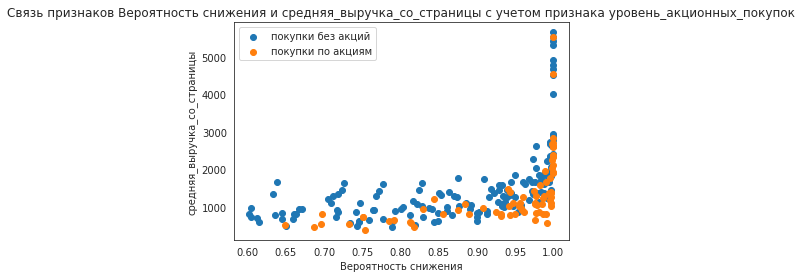

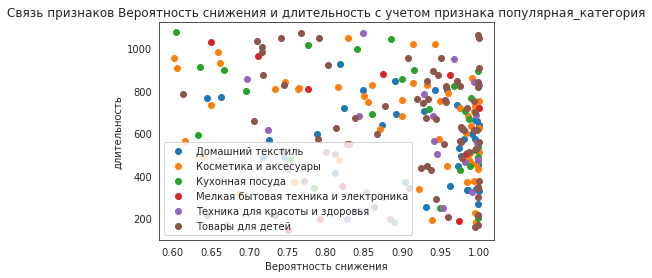

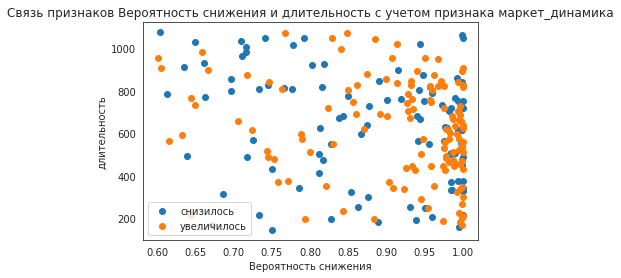

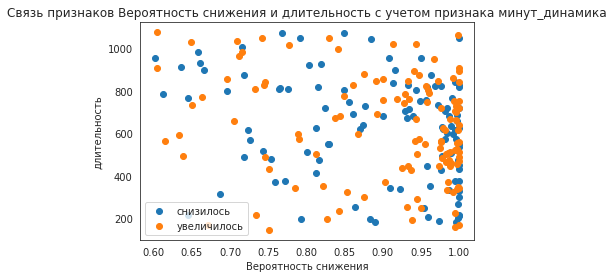

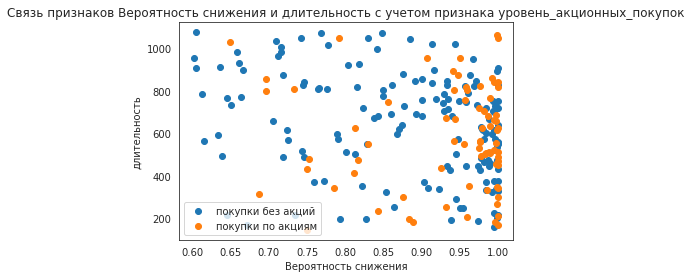

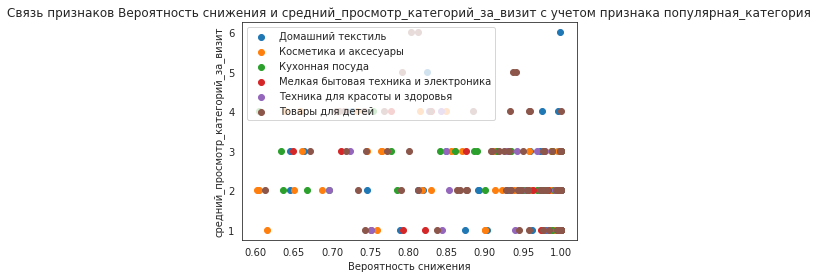

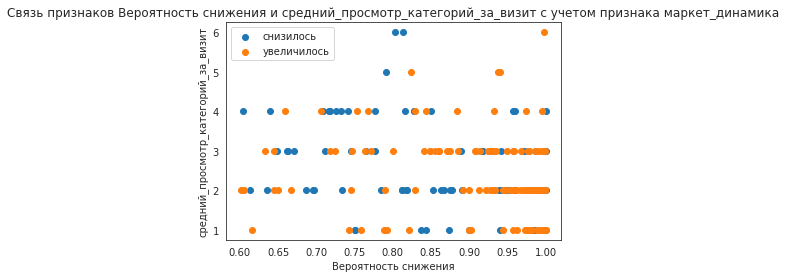

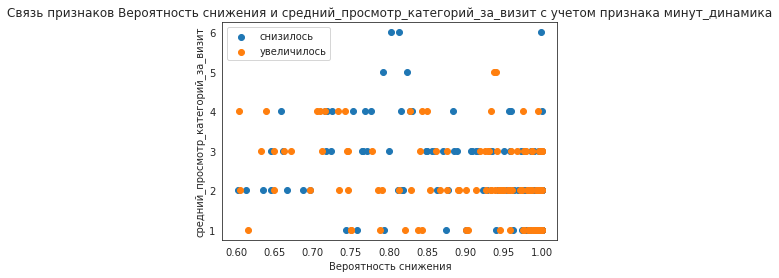

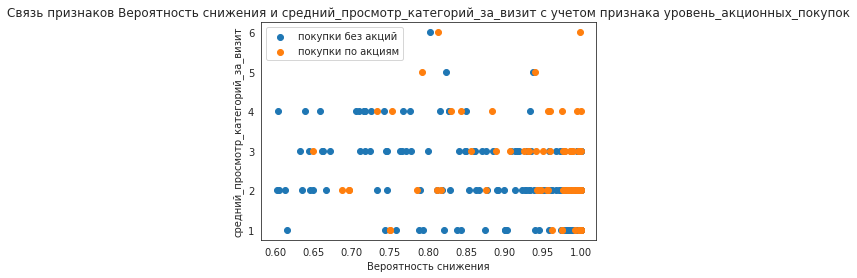

In [46]:
quantitative_fields=['выручка_среднее', 'средняя_выручка_со_страницы','длительность','средний_просмотр_категорий_за_визит']
categorical_fields = ['популярная_категория','маркет_динамика','минут_динамика','уровень_акционных_покупок']
get_scatters(market_explored,'вероятность_снижения',quantitative_fields,categorical_fields,'Вероятность снижения')

Исследование группы показало, что вероятность снижения покупательской активности выше у клиентов:

- со средним просмотром категорий за визит менее трех
- длительностью использования сервиса менее 800 дней, т.е. за давних клиентов можно быть спокойным
- средней выручкой со страницы более 2000, т.е. приобретающих разовые дорогостоящие покупки и/или просматривающие мало страниц
- средней выручкой за 3 месяца менее 4500
- преимущественно покупающих по акции
- покупающих в категории Товары для детей
- за последний месяц получающих рассылки чаще среднего
- за последний месяц увеличивших свое время пребывания на сайте

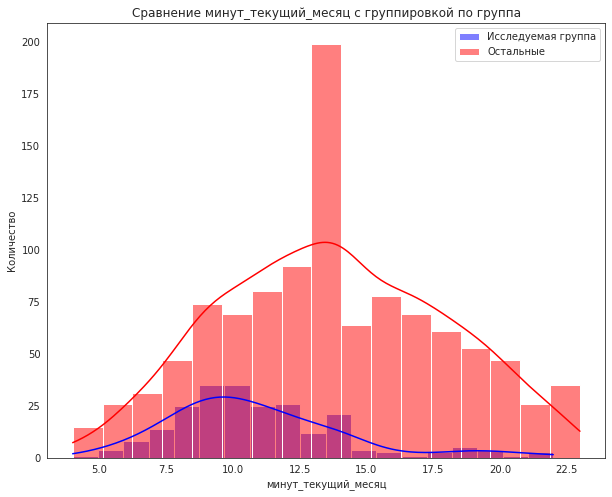

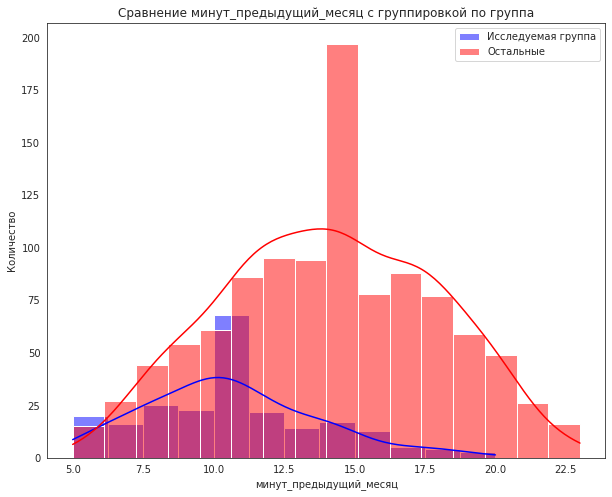

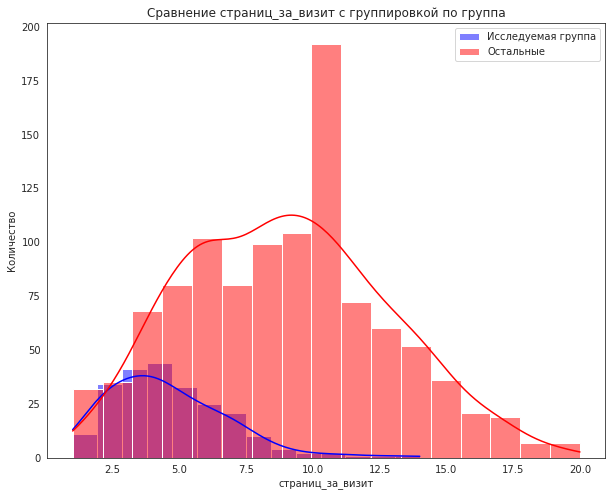

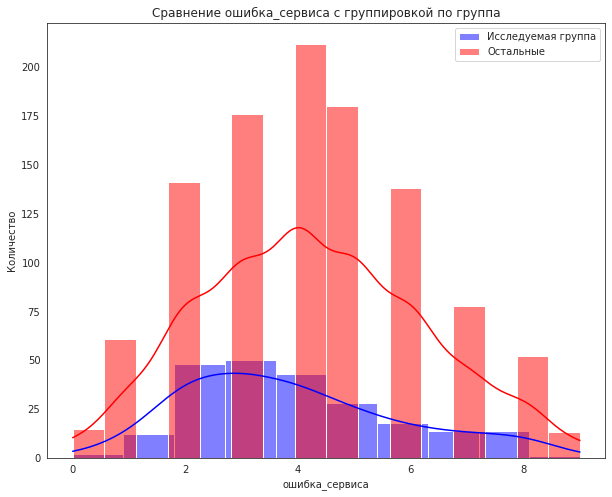

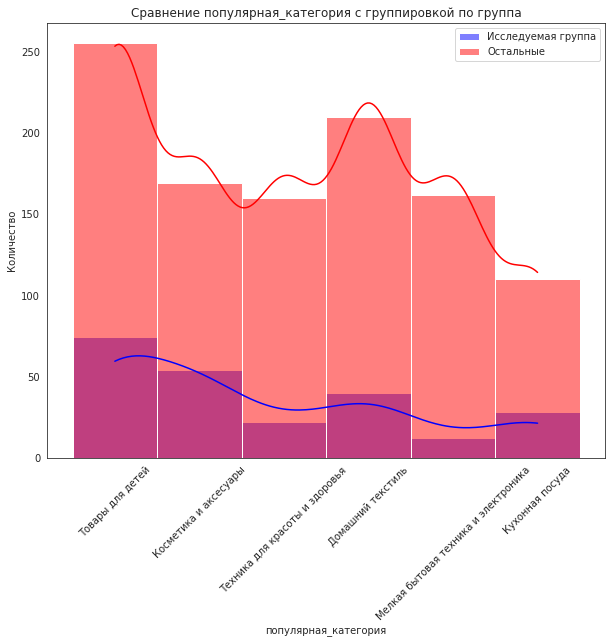

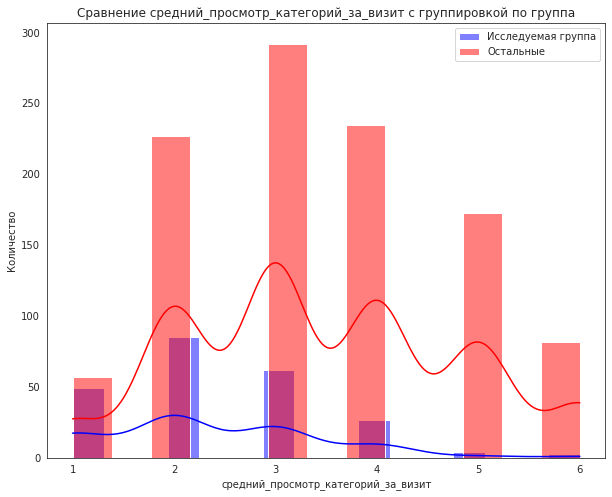

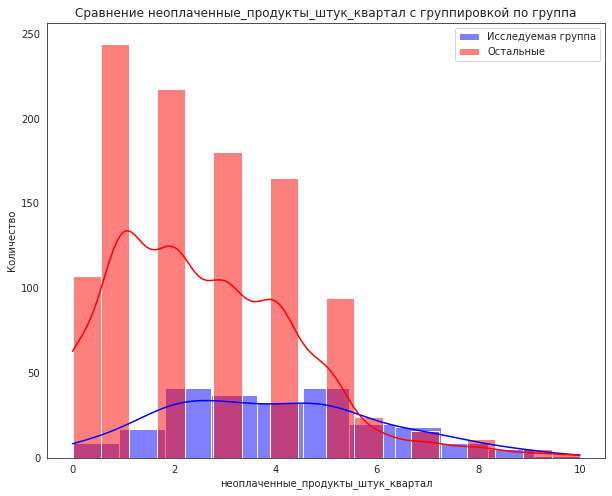

In [47]:
quantitative_fields=['минут_текущий_месяц','минут_предыдущий_месяц','страниц_за_визит','ошибка_сервиса',
                     'популярная_категория','средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал']
categorical_fields = ['группа']
get_hists(market,quantitative_fields,categorical_fields)

Сравнение исследуемой группы с остальными показало, что для исследуемой группы харакетерно :

- меньшее количество минут на сайте за посещение
- меньшее количество страниц, просмотренных за посещение
- меньшее количество категорий, просмотренных за посещение
- меньшее количество ошибок, т.е. эта группа клиентов чувствительнее к наличию ошибок сервиса
- распределение по категориям аналогичное, однако можно выделить группы товары для детей, косметика и аксессуары и технику для здоровья и красоты, как наиболее популярные
- большее количество неоплаченных товаров в корзине


**Выводы**

Были выделены 4 сегмента по соотношению вероятности снижения покупательской активности к прибыли:

    группа клиентов с высокой прибылью и высокой вероятностью снижения покупательской активности
    группа клиентов с высокой прибылью и низкой вероятностью снижения покупательской активности
    группа клиентов с низкой прибылью и высокой вероятностью снижения покупательской активности
    группа клиентов с низкой прибылью и низкой вероятностью снижения покупательской активности

Для подробного изучения был выбран первый сегмент.


Анализ параметров, отвечающих за продуктовое поведение и поведение на сайте, позволяет сделать следующие рекомендации:

    - клиенты, проводящие на сайте менее 10 минут, имеют склонность к снижению покупательской активности
    - то же можно сказать о клиентах, посещающих менее 5 страниц за визит или просматривающих менее 3 категорий за посещение
    - клиенты, приносящие высокую прибыль, чувствительнее к возникновению ошибок на сайте
    - особое внимание следует уделить клиентам из категорий товары для детей, косметика и аксессуары и техника для красоты
    - для клиентов со снижением покупательской активности свойственно большое количество неоплаченных товаров в корзине
    - требуется дополнительное стимулирование клиентов, делающие разовые дорогостоящие покупки, и клиентов, преобретающих преимущественно по акциям.  
    
В качестве мер по увеличению покупательской активности среди клиентов, чаще покупающих без акций, можно порекомендовать:

    - увеличение вовлеченности клиентов при работе с сайтом: стимулирование к просмотру большего количества страниц, категорий, наполнение контентом, увеличивающим время нахождения клиента на сайте
    - тщательное устранение ошибок сервиса
    - введение напоминаний о наличии неоплаченных товаров в корзине, возможно рассылки, предложение особых условий покупки и пр.
    - особое внимание к категориям Товары для детей, Косметика и аксессуары и Товары для красоты и здоровья

## Общий вывод

В рамках проекта требовалось разработать решение для интернет-магазина, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

В качестве материала для исследования были предоставлены данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, данные о выручке и прибыли, которую получает магазин с покупателя.

Все представленные датасеты проверены и в них:

- исправлены наименования столбцов
- типы данных исправлены на корректные (при необходимости)
- удалены дубликаты категориальных значений (при необходимости)
- проведена проверка на полные дубликаты

Проведен исследовательский и корреляционный анализ, в рамках которого были изучены данные, добавлены дополнительные параметры, определены параметры, приводящие к мультиколлениарности с целевым признаком.

Определена лучшая модель - LogisticRegression с настройками C=4, class_weight='balanced', penalty='l1',  solver='liblinear', значение метрики ROC-AUC 0 0,889 на тренировочной и 0,9 на тестовой выборке.


Для подробного изучения был выбран сегмент с высокой прибылью и высокой вероятностью снижения покупательской активности.


Анализ параметров, отвечающих за продуктовое поведение и поведение на сайте, позволяет сделать следующие рекомендации:

    - клиенты, проводящие на сайте менее 10 минут, имеют склонность к снижению покупательской активности
    - то же можно сказать о клиентах, посещающих менее 5 страниц за визит или просматривающих менее 3 категорий за посещение
    - клиенты, приносящие высокую прибыль, чувствительнее к возникновению ошибок на сайте
    - особое внимание следует уделить клиентам из категорий товары для детей, косметика и аксессуары и техника для красоты
    - для клиентов со снижением покупательской активности свойственно большое количество неоплаченных товаров в корзине
    - требуется дополнительное стимулирование клиентов, делающие разовые дорогостоящие покупки, и клиентов, преобретающих преимущественно по акциям.  
    
В качестве мер по увеличению покупательской активности среди клиентов, чаще покупающих без акций, можно порекомендовать:

    - увеличение вовлеченности клиентов при работе с сайтом: стимулирование к просмотру большего количества страниц, категорий, наполнение контентом, увеличивающим время нахождения клиента на сайте
    - тщательное устранение ошибок сервиса
    - введение напоминаний о наличии неоплаченных товаров в корзине, возможно рассылки, предложение особых условий покупки и пр.
    - особое внимание к категориям Товары для детей, Косметика и аксессуары и Товары для красоты и здоровья